In [1]:
# %load defaults.ipy
from numpy import *
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline

import matplotlib.pyplot as plt


import sys
import os
import os.path
sys.path.append('../python')

import plot_info
from plot_info import showAndSave
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import copy
import json
import traceback
with open('structure_function_configs.json') as f:
    configurations = json.load(f)

def for_each_config(f):
    oldPrefix = copy.deepcopy(showAndSave.prefix)
    for conf in configurations.keys():
        
        plot_info.console_log(conf)
        headline(configurations[conf]['name'])
        showAndSave.prefix = oldPrefix + conf
        try:
            f(configurations[conf])
        except Exception as e:
            message = "Skipping {fname} on {conf} ({confname})\n\tReason: {reason}\nTraceback: {traceback}".format(fname=str(f),
                                                                                                       conf=conf, 
                                                                                                       confname=configurations[conf]['name'],
                                                                                                       reason=str(e),
                                                                                                     traceback=traceback.format_exc())
            plot_info.console_log(message)
            print(message)
    showAndSave.prefix=oldPrefix

plot_info.set_notebook_name("structure_postprocess.ipynb")

In [2]:
def headline(text):
    display(HTML("<h1>%s</h1>"%text))
def h2(text):
    display(HTML("<h2>%s</h2>"%text))
def h3(text):
    display(HTML("<h3>%s</h3>"%text))
def h4(text):
    display(HTML("<h4>%s</h4>"%text))
def h5(text):
    display(HTML("<h4>%s</h4>"%text))

In [3]:
def readnetcdf4(filename, variable):
    
    with netCDF4.Dataset(filename) as f:
        return f.variables[variable][:,0,0]

def upscale(d, r):

    while d.shape[0] < r:
       
        d = repeat(d,2,0)
    return d

def plotscalings_perturbation(d,pert, title,plot_nonlog=True,name=''):
    N = len(d)
    H = linspace(0, 64./2048,N)
   
    poly = polyfit(log(H[1:]),log(d[1:]),1)
  
  
        
    fig = plt.figure(0,figsize=2*plt.figaspect(0.9))
    plt.title(title)
    ax = plt.gca()
    ax.loglog(H[1:],d[1:],label='%s $\\epsilon=%.4f$'%(name, pert))
    ax.loglog(H[1:], exp(poly[1])*H[1:]**(poly[0]), '--',label='$\\mathcal{O}(h^{%.2f})$' % poly[0])
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                 box.width, box.height * 0.9])
    #
    ## Put a legend below current axis
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    ax.grid('on')



def plotscalings(d,r,title,plot_nonlog=True):
    N = len(d)
    H = linspace(0, 64./2048,N)
   
    poly = polyfit(log(H[1:]),log(d[1:]),1)
    if plot_nonlog:
        fig = plt.figure(0, figsize=2*plt.figaspect(0.5))
        fig.suptitle(title)
        ax = fig.add_subplot(1,2,1)
        
        ax.plot(H,d,label='r=%d'%r)
        ax.plot(H, exp(poly[1])*H**(poly[0]), '--',label='$\\mathcal{O}(h^{%.2f})$' % poly[0])
        ax.grid('on')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        
        # Put a legend below current axis
        #ax.legend(pos='upper center', bbox_to_anchor=(0.5, -0.05),
        #     fancybox=True, shadow=True, ncol=5)
        
        ax.legend(bbox_to_anchor=(0.5, -0.05),
             fancybox=True, shadow=True, ncol=5)
        
    
          

        ax = fig.add_subplot(1,2,2)
    else:
        
        fig = plt.figure(0)#,figsize=2*plt.figaspect(0.9))
        plt.title(title)
        ax = plt.gca()
    p = ax.loglog(H[1:],d[1:],label='$N=%d$'%r)
    ax.loglog(H[1:], exp(poly[1])*H[1:]**(poly[0]), '--',
              label='$\\mathcal{O}(h^{%.2f})$' % poly[0],
             color=p[0].get_color(), basex=2, basey=2)
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                 box.width, box.height * 0.9])
    #
    ## Put a legend below current axis
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    
    #print(f'structure["{title}"][{r}] = {repr(d)}')
    plot_info.legendLeft()
    ax.grid('on')




def getlineintegral(filename, variable,resolution):
    d = readnetcdf4(filename, variable)
    dx = 1.0/resolution
    
    for h in range(1,len(d)):
        d[h] += d[h-1]
    for h in range(1,len(d)):
        d[h] /=(2*h+1)**2
        
    #if 'cuda' not in filename and resolution < 256:
    #    d /= resolution**3
        
    return d
    

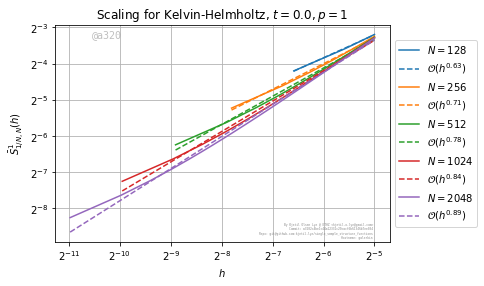

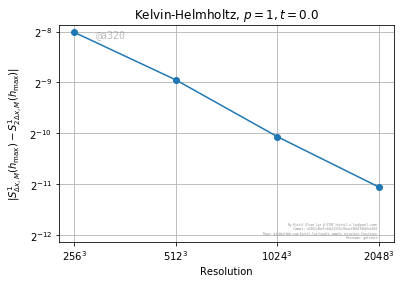

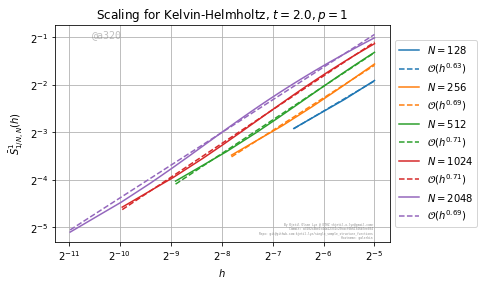

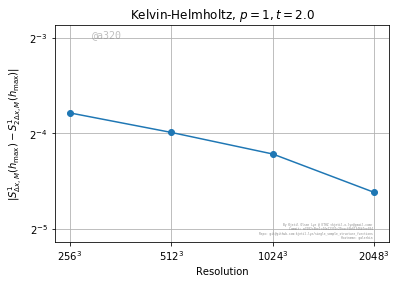

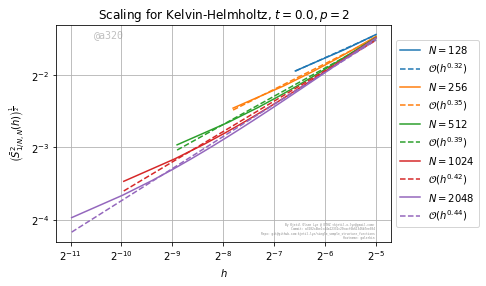

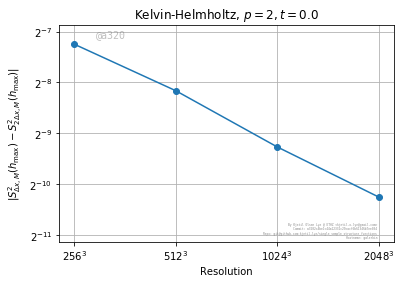

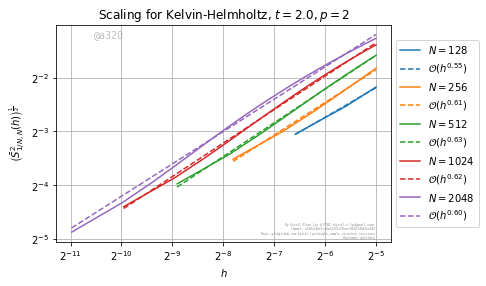

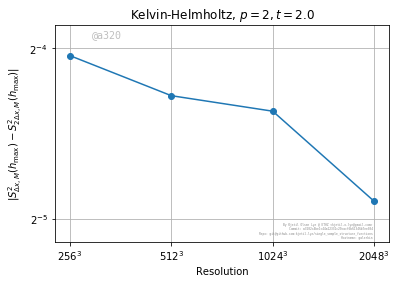

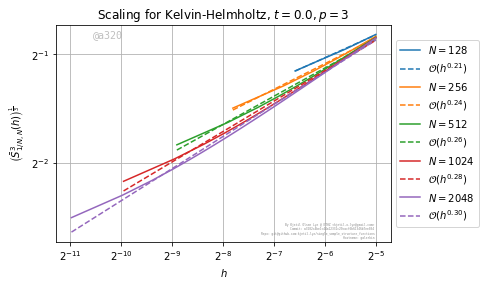

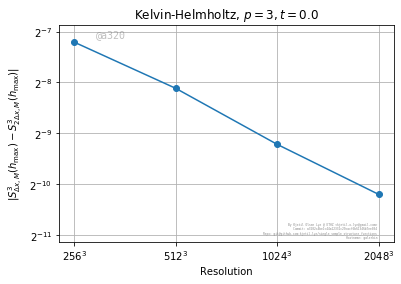

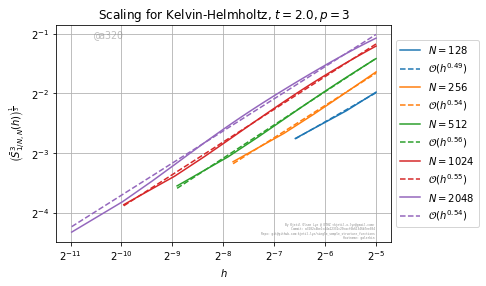

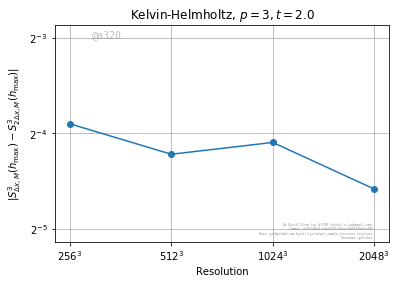

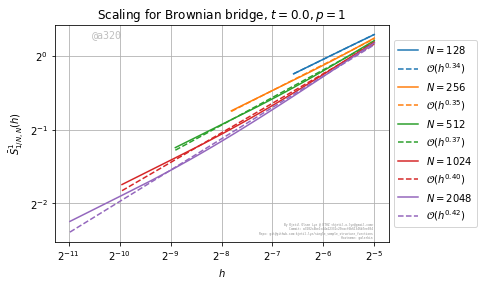

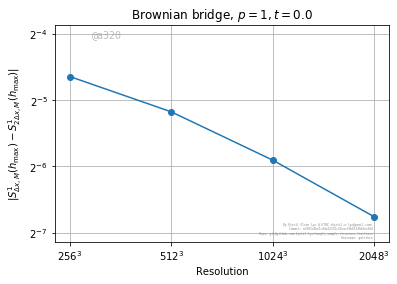

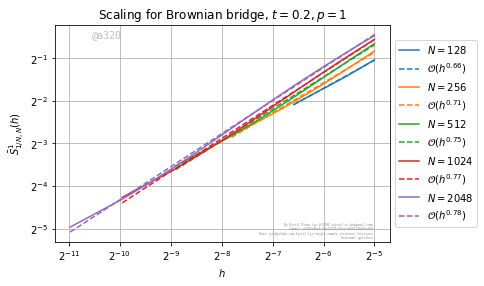

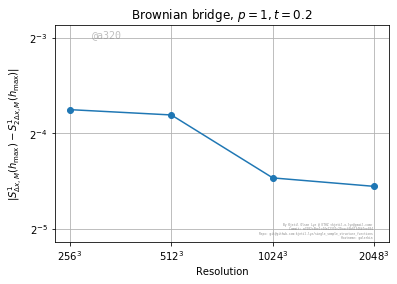

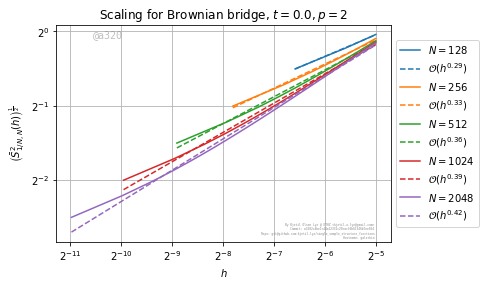

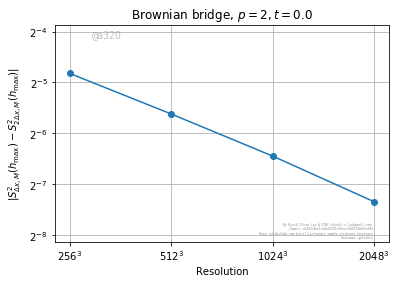

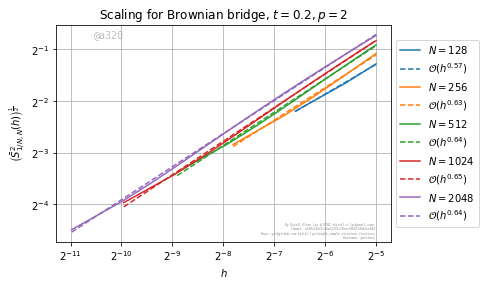

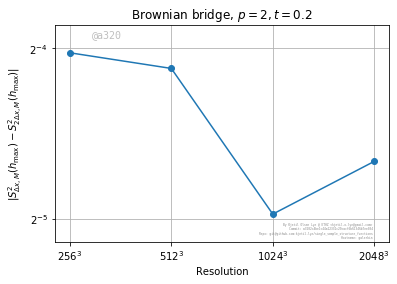

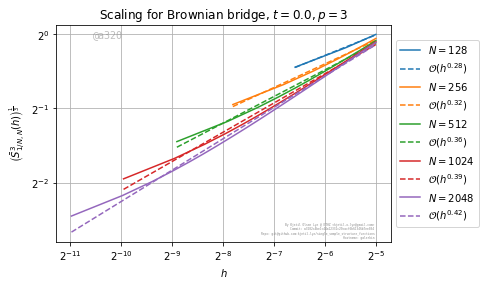

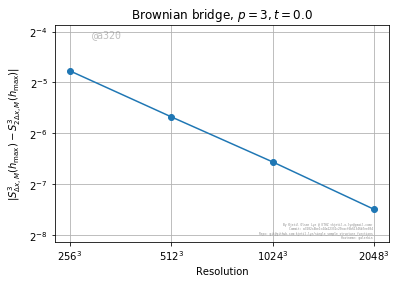

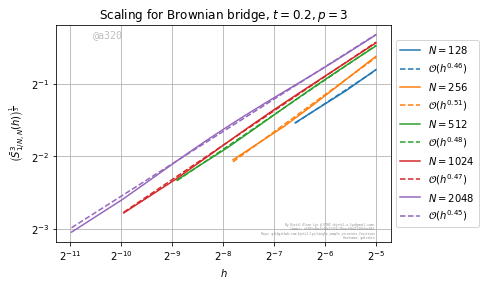

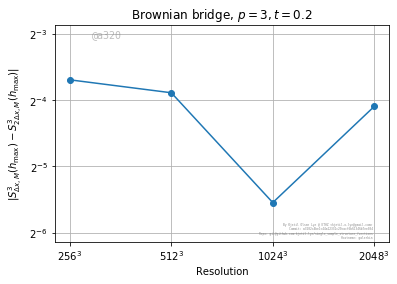

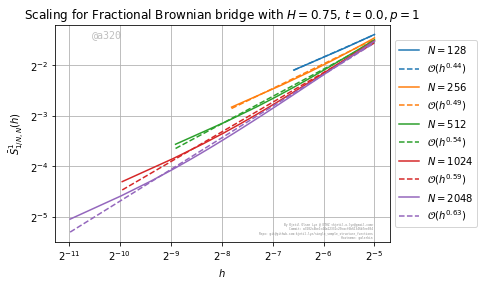

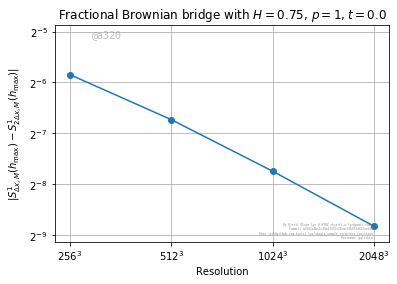

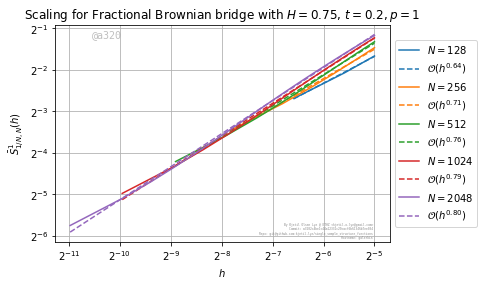

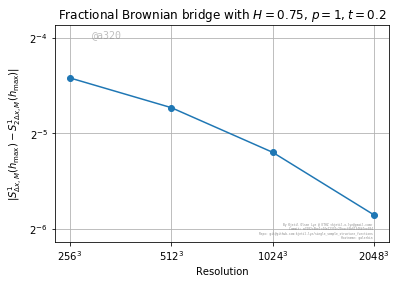

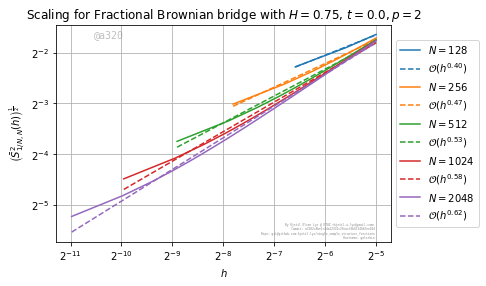

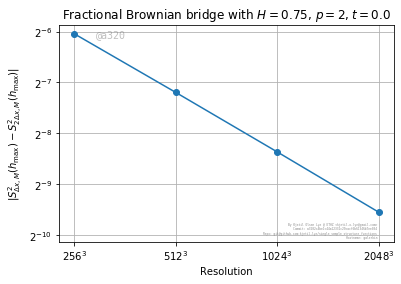

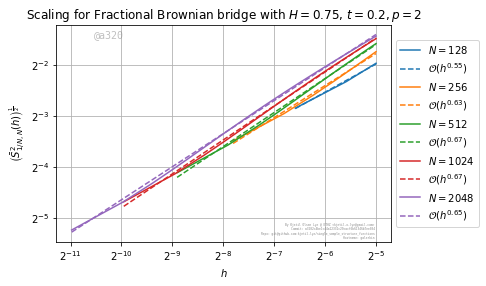

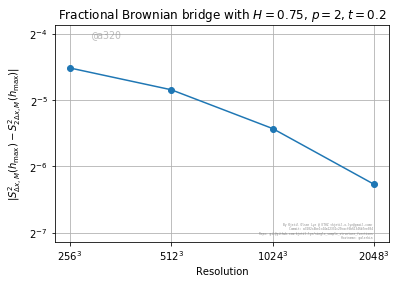

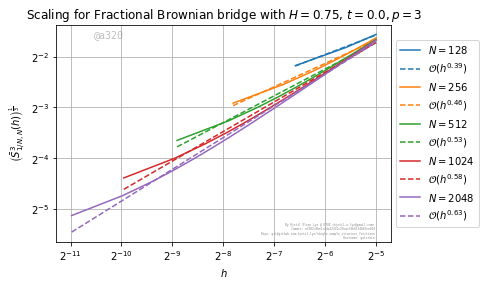

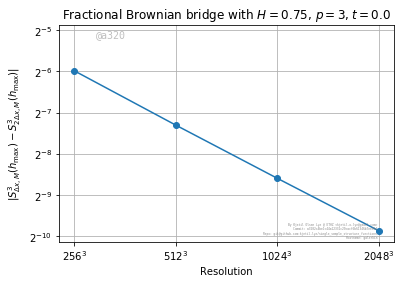

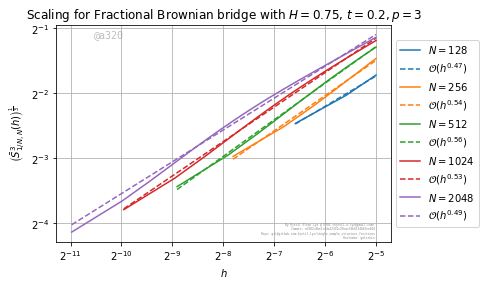

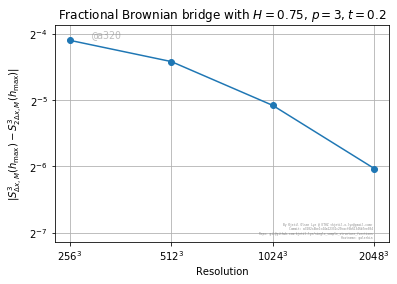

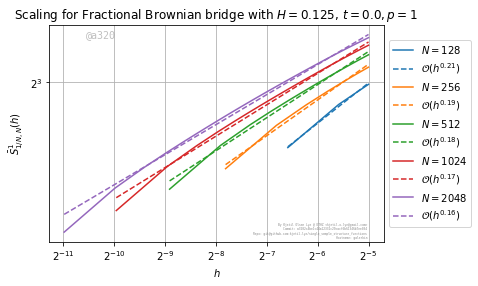

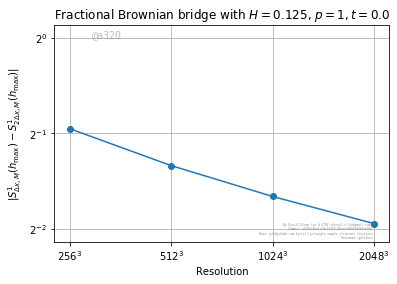

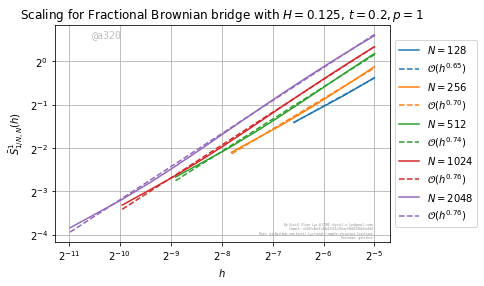

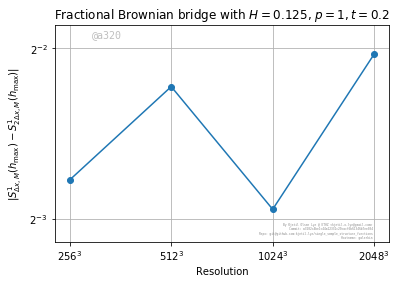

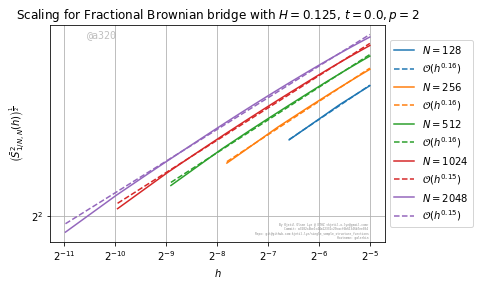

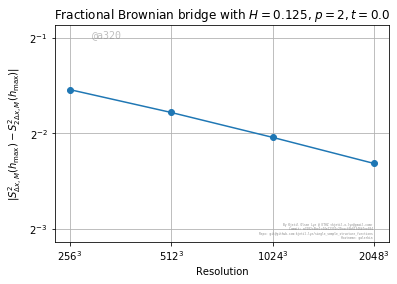

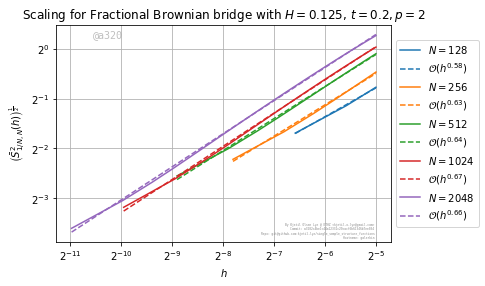

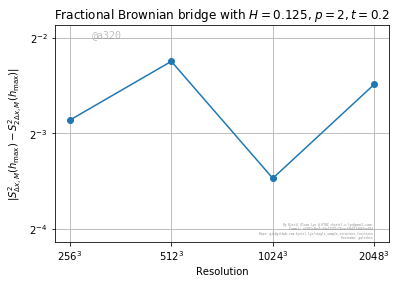

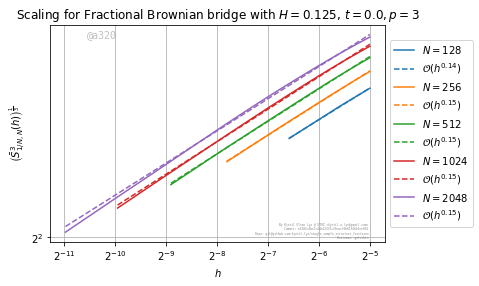

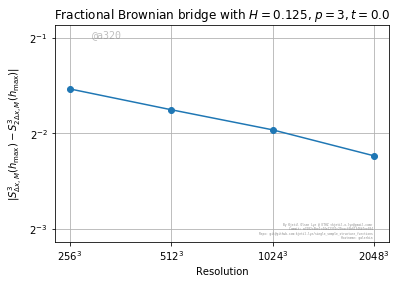

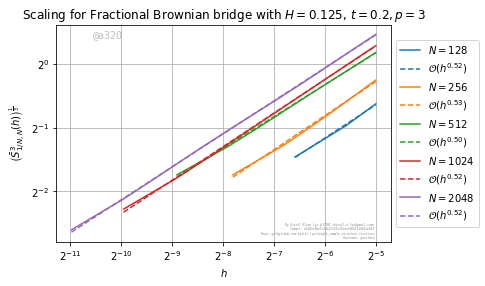

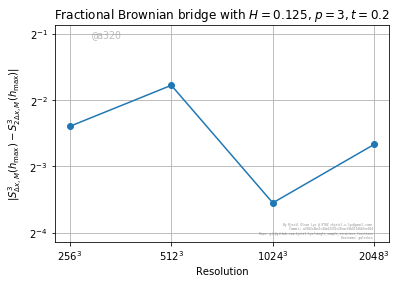

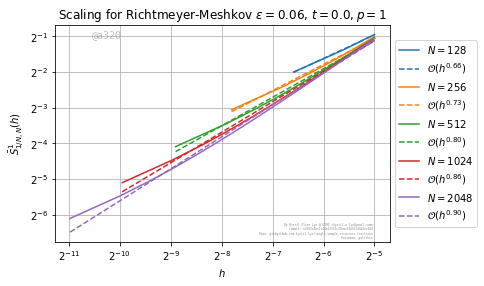

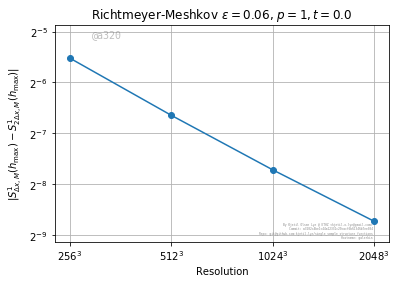

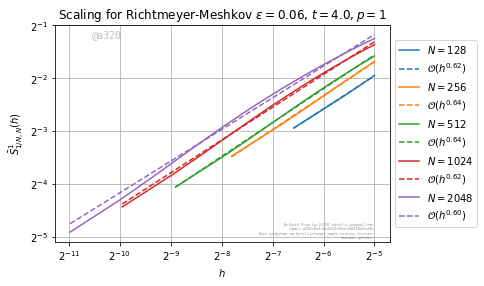

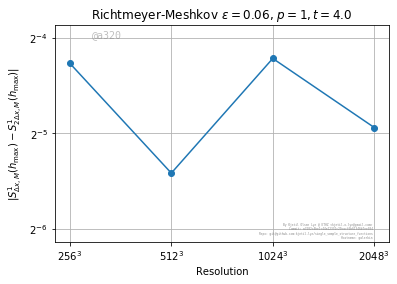

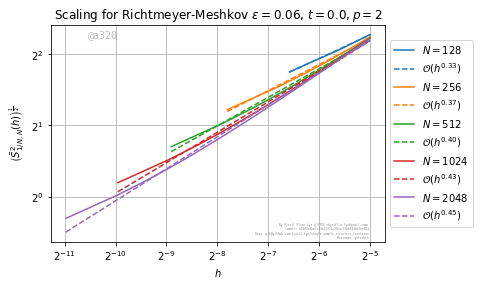

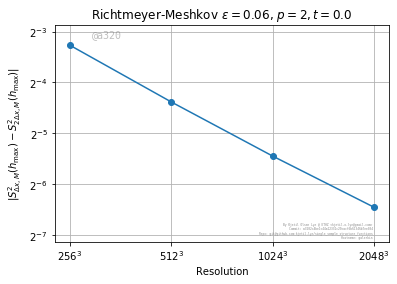

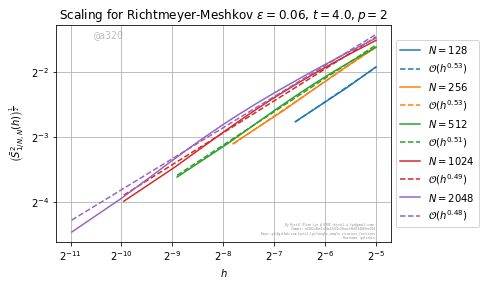

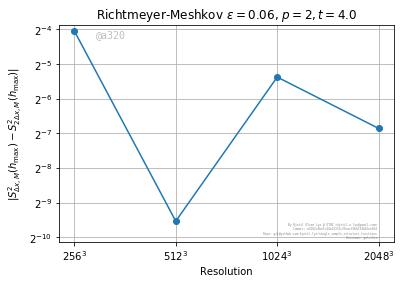

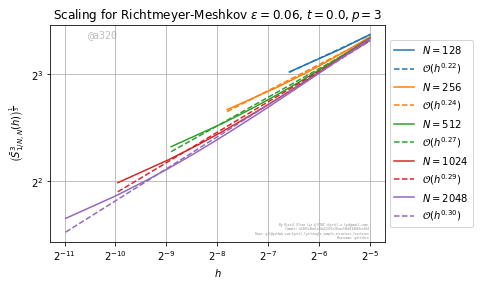

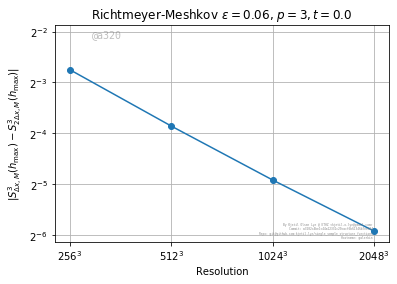

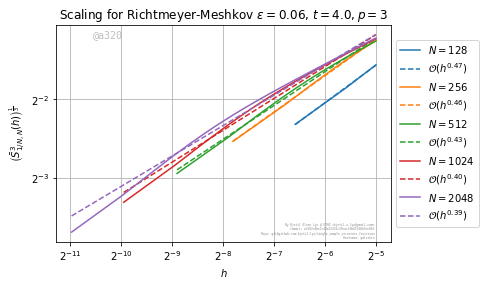

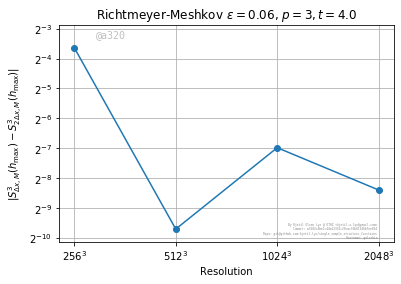

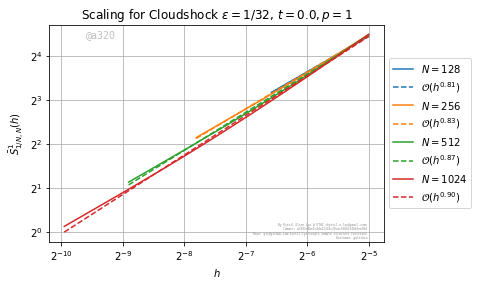

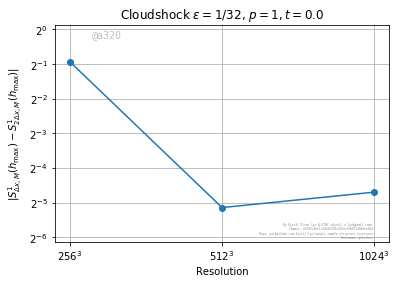

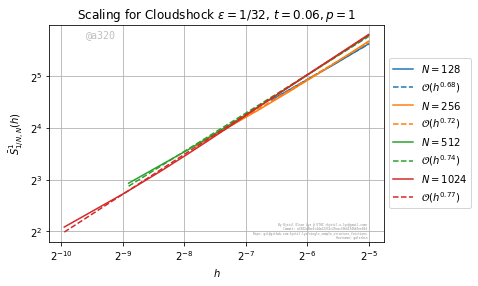

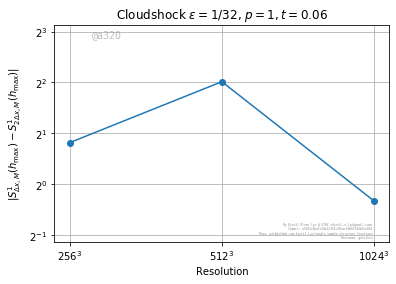

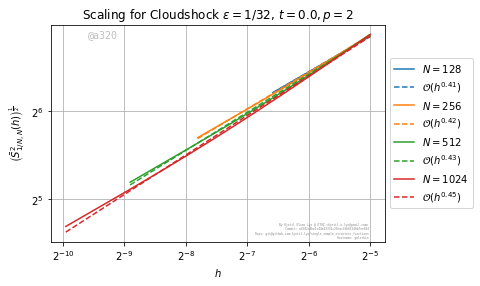

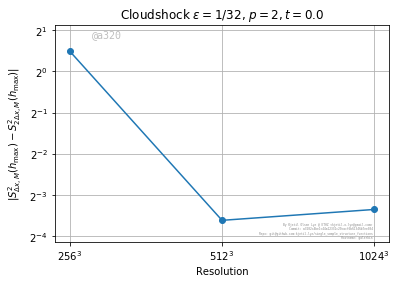

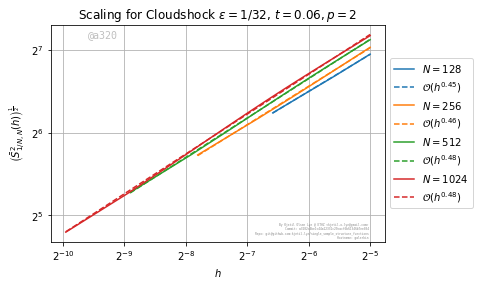

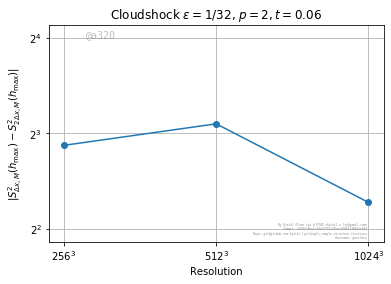

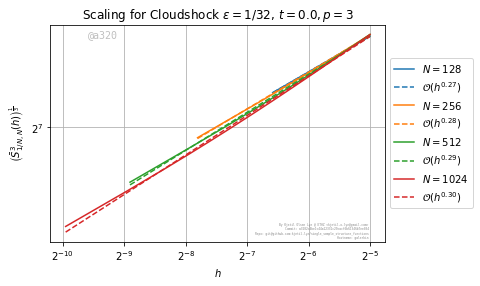

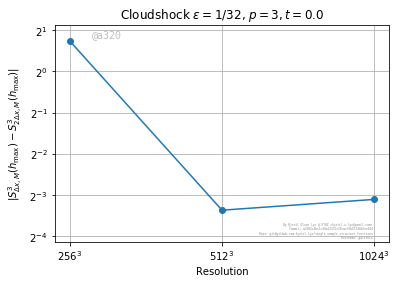

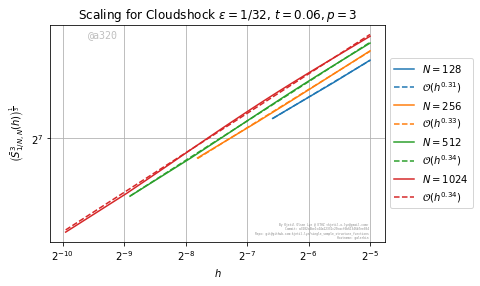

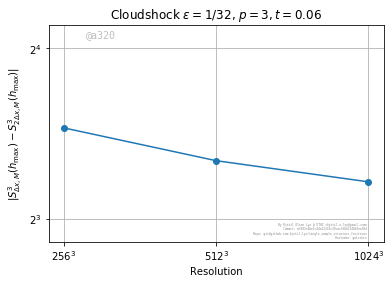

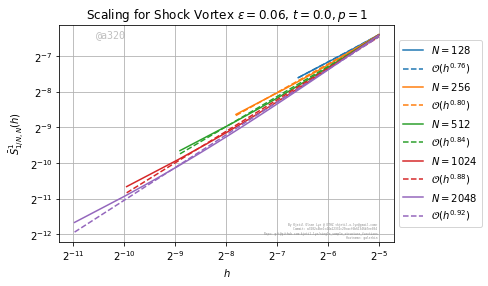

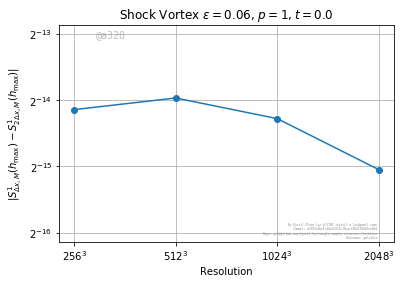

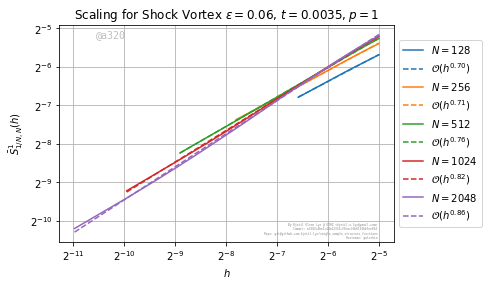

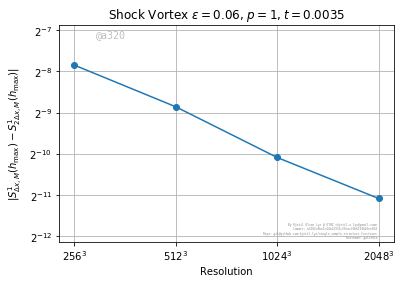

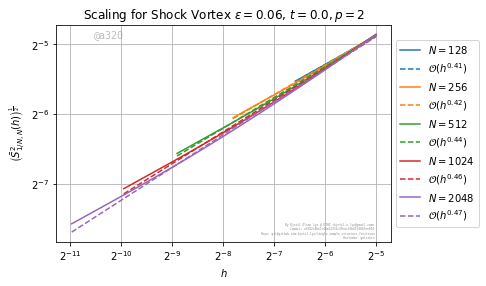

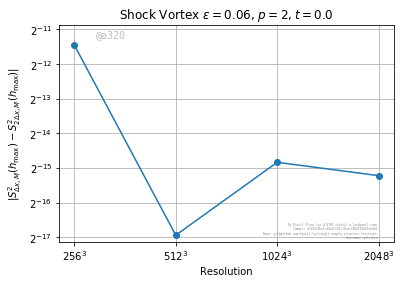

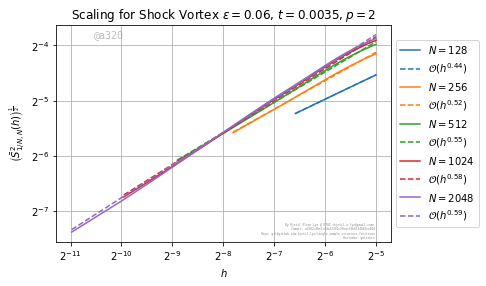

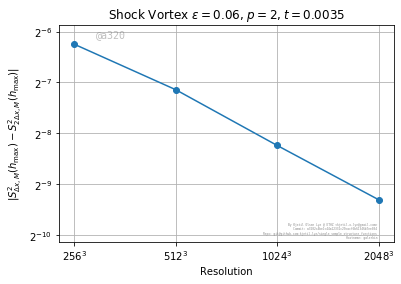

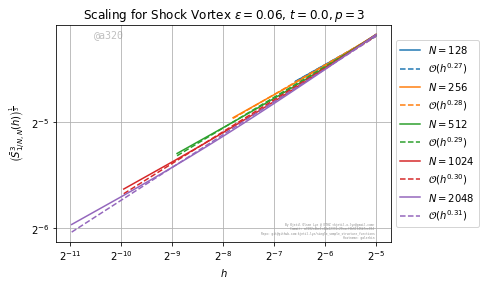

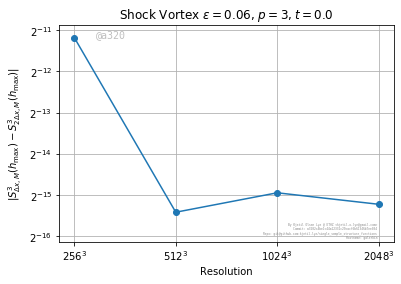

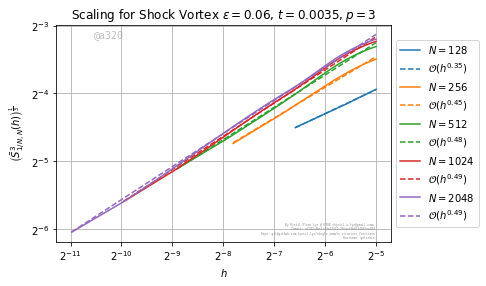

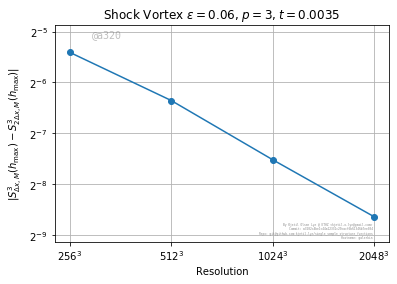

In [4]:
def convergence_structure_functions(config):
    headline("Component convergence Box averaged structure functions")
    variables = ['rho', 'mx','my', 'E']
    perturbations = config['perturbations']
    Tarray = config['Tarray']
    resolutions = config['resolutions']
    cube_filename = config['cube_filename']
    name = config['name']
    maxT = config['maxT']
    for perturbation in perturbations:
        h2("perturbation = %.2f" % perturbation)
        for p in [1,2,3]:
            h3("p = %d" % p)
            timeArray = Tarray
                
            for t in timeArray:
                h4("t = %f" % (0.2*t))

                errors = zeros(len(resolutions)-1)


                for (nr, resolution) in enumerate(resolutions):
                    dVar = zeros((64*resolution)//2048)
                    for variable in variables:

                        filename = cube_filename.format(perturbation = perturbation, p=p,t=t,resolution=resolution)

                        d = getlineintegral(filename, variable, resolution)


                        dVar += d
                    dVar = dVar**(1.0/p)
                    if resolution > resolutions[0]:
                        errors[nr-1] = abs(dVar[-1]-dPrev[-1])
                    dPrev = repeat(dVar,2,0)
                    
                    t_start = config.get("t_start", 0.0)
                    time = t_start
                    if max(timeArray) > 0:
                        time += t * maxT / max(timeArray)
                    if len(perturbations) > 1:
                        title = f'Scaling for {name}, $t={time},p={p},\\varepsilon={perturbation}$'
                    else:
                        title = f'Scaling for {name}, $t={time},p={p}$'

                    plotscalings(dVar, resolution, title, False)
                    plt.xlabel('$h$')
                    if p != 1:
                        plt.ylabel('$\\left(\\bar{S}^{%d}_{1/N,N}(h)\\right)^{\\frac{1}{%d}}$' % (p,p))
                    else:
                        
                        plt.ylabel('$\\bar{S}^{%d}_{1/N,N}(h)$' % (p))
                for nr in range(len(resolutions)-1):
                    errors[nr] = abs(errors[nr])

                showAndSave('scaling_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                plt.loglog(resolutions[1:],errors,'-o',label='%s' % variable, basex=2, basey=2)
                
                plt.ylim([2.0**(np.floor(np.log2(min(errors))))/1.1, 1.1*2.0**(np.ceil(np.log2(max(errors))))])
                if len(perturbations)>1:
                    title = f'{name}, $p={p}, t={time}, \\varepsilon={perturbation}$'
                else:
                    title = f'{name}, $p={p}, t={time}$'

                #plt.title('{name}, $p={p}, t={t}, \\varepsilon={perturbation}$'.format(name=name, perturbation=perturbation, p=p,t=t*maxT/float(max(Tarray))))

                plt.title(title)
                plt.xlabel('Resolution')
                plt.ylabel('$|S^{%d}_{\Delta x,M}(h_{\\max})-S^{%d}_{2\Delta x,M}(h_{\\max})|$' % (p,p) )
                plt.grid('on')
                plt.xticks(resolutions[1:], ['${r}^3$'.format(r=r) for r in resolutions[1:]])
                showAndSave('convergence_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                
for_each_config(convergence_structure_functions)